In [2]:
import pickle
import pandas as pd
import numpy as np
from datetime import datetime
from dateutil.relativedelta import relativedelta
import warnings
warnings.filterwarnings("ignore")
from tqdm.auto import tqdm
import pingouin as pg
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import rc
import matplotlib as mpl

# define data path
with open('data_path.txt') as f:
    lines = f.read().splitlines()
data_path = lines[0]

# load key data
f = open(data_path+'clean_data.pckl', 'rb')
mcdata, keydata, ids, returns, EU_4F, US_4F = pickle.load(f)
f.close()

# load betas
f = open(data_path+'betas.pckl', 'rb')
betas_onlyMkt, betas_4FBMG, betas_4F, betas_onlyBMG,betas_onlyBMG2, all_sample, bmg_sample = pickle.load(f)
f.close()

# load bmg data
f = open(data_path+'bmg.pckl', 'rb')
bmg_factors_value, bmg_factors_equal, valid_dict = pickle.load(f)
f.close()




In [2]:
# return statistics of univariate portfolio sorts
portfolio_sorts_df = pd.DataFrame(columns = ["Portfolio","MeanExcess","3F_Alpha","4F_Alpha"])

#define start and end date
start_date = pd.Timestamp("2009-01-31")
end_date = pd.Timestamp("2019-12-31")

# factor series (use US factors)
factors = US_4F.loc[US_4F[US_4F.Date == start_date].index.item():US_4F[US_4F.Date == end_date].index.item()]
factors = factors.reset_index(drop=True)

# portfolios df
port_returns = bmg_factors_value.copy()
port_returns = port_returns.loc[port_returns[port_returns.Date == start_date].index.item():port_returns[port_returns.Date == end_date].index.item()]
port_returns = port_returns.reset_index(drop=True)

for c in bmg_factors_value.columns[1:]:
    return_series = port_returns[[c]]
    #convert to floats
    return_series = return_series.astype(float)
    
    median = np.median(return_series[c])
    std = np.std(return_series[c])
    mean = np.mean(return_series[c])
    
    return_series[c] -= factors["RF"]
    
    std_ex = np.std(return_series[c])
    mean_ex = np.mean(return_series[c])
    
    sharpe = mean_ex/std_ex
    
    mean_p = pg.ttest(return_series[c],0)["p-val"].item()
    
    #beta values
    x_3F = factors[["Mkt-RF","SMB","HML"]]
    
    #3F
    lm_3F = pg.linear_regression(x_3F,return_series[c])
    
    f3_alpha = lm_3F[lm_3F.names == "Intercept"]["coef"].item()
    f3_t = lm_3F[lm_3F.names == "Intercept"]["T"].item()
    f3_p = lm_3F[lm_3F.names == "Intercept"]["pval"].item()
    
    # 4F
    x_4F = factors[["Mkt-RF","SMB","HML","WML"]]
    
    #Regression
    lm_4F = pg.linear_regression(x_4F,return_series[c])
    
    f4_alpha = lm_4F[lm_4F.names == "Intercept"]["coef"].item()
    f4_t = lm_4F[lm_4F.names == "Intercept"]["T"].item()
    f4_p = lm_4F[lm_4F.names == "Intercept"]["pval"].item()
    
    
    temp_df = pd.DataFrame({
    "Portfolio":[c],
    "Mean":[mean],
    "MeanExcess":[mean_ex],
    "Std":[std],  
    "Median":[median],
    "SharpeRatio":[sharpe],
    "MeanExpvalue":[mean_p],
    "3F_Alpha":[f3_alpha],
    "3F_t":[f3_t],
    "3F_p":[f3_p],
    "4F_Alpha":[f4_alpha],
    "4F_t":[f4_t],
    "4F_p":[f4_p]
    })

    portfolio_sorts_df = portfolio_sorts_df.append(temp_df)
    
    quint = c
    
portfolio_sorts_df = portfolio_sorts_df.reset_index(drop=True)
portfolio_sorts_df
    

,Portfolio,MeanExcess,3F_Alpha,4F_Alpha,Mean,Std,Median,SharpeRatio,MeanExpvalue,3F_t,3F_p,4F_t,4F_p
0,Small_Green,1.853548,0.850581,0.841163,1.893018,4.324984,2.518012,0.428236,2.762318e-06,4.202106,0.000049,4.358807,0.000027
1,Small_Neutral,1.872695,0.796821,0.782884,1.912164,4.507372,1.808532,0.415022,5.260127e-06,4.002699,0.000105,4.442578,0.000019
2,Small_Brown,1.826761,0.798384,0.787079,1.866230,4.511510,1.808978,0.404535,8.689993e-06,3.894729,0.000158,4.119343,0.000068
3,Big_Green,1.628637,0.515566,0.512925,1.668107,3.556238,1.867073,0.457919,6.215693e-07,4.400264,0.000023,4.411405,0.000022
4,Big_Neutral,1.272834,0.291692,0.293634,1.312304,3.180409,1.484097,0.399999,1.077004e-05,2.976746,0.003485,3.011555,0.003137
5,Big_Brown,1.074824,0.112706,0.109855,1.114294,3.765953,1.308979,0.285387,1.390506e-03,0.709281,0.479440,0.693664,0.489160
6,Q20,1.824012,0.644542,0.639419,1.863481,4.002489,2.183600,0.455782,6.933967e-07,3.974401,0.000117,4.019180,0.000099
7,Q40,1.425589,0.401834,0.401847,1.465058,3.305738,1.790704,0.431006,2.409695e-06,3.627137,0.000413,3.612750,0.000435
8,Q60,1.291509,0.312431,0.313341,1.330978,3.263208,1.486915,0.395449,1.333550e-05,2.855454,0.005016,2.856808,0.005001
9,Q80,1.153512,0.175237,0.174935,1.192982,3.459759,1.436581,0.333114,2.107278e-04,1.318315,0.189753,1.310932,0.192246


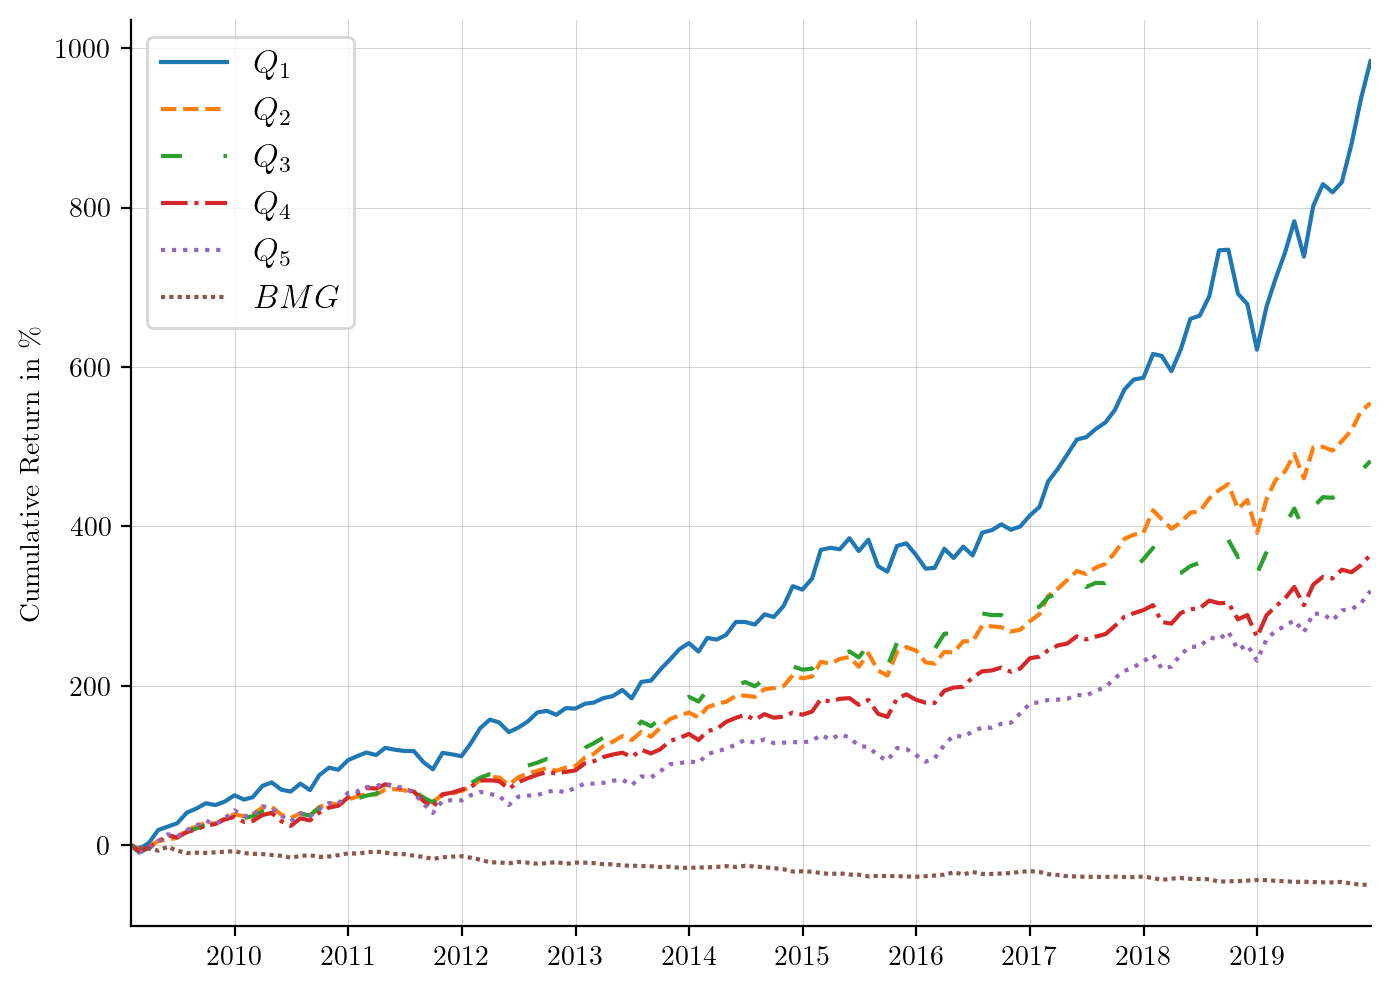

In [8]:
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('font',**{'family':'serif','serif':['Times New Roman']})
rc('text', usetex=True)

mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

plot_returns = bmg_factors_value.copy()

start_index = plot_returns[plot_returns.Date == start_date].index.item()
end_index = plot_returns[plot_returns.Date == end_date].index.item()

plot_returns = plot_returns.loc[start_index:end_index]
plot_returns = plot_returns.reset_index(drop=True)

figure(figsize=(8, 6), dpi=200)

plot_returns.loc[0,1:] = 0

cum_returns = (((plot_returns["Q20"]/100) + 1).cumprod()-1)*100
plt.plot(plot_returns["Date"],cum_returns,linewidth=1.5,label='$Q_1$',linestyle="solid")

cum_returns = (((plot_returns["Q40"]/100) + 1).cumprod()-1)*100
plt.plot(plot_returns["Date"],cum_returns,linewidth=1.5,label='$Q_2$',linestyle="dashed")

cum_returns = (((plot_returns["Q60"]/100) + 1).cumprod()-1)*100
plt.plot(plot_returns["Date"],cum_returns,linewidth=1.5,label='$Q_3$',linestyle=(0, (5, 10)))

cum_returns = (((plot_returns["Q80"]/100) + 1).cumprod()-1)*100
plt.plot(plot_returns["Date"],cum_returns,linewidth=1.5,label='$Q_4$',linestyle="dashdot")


cum_returns = (((plot_returns["Q100"]/100) + 1).cumprod()-1)*100
plt.plot(plot_returns["Date"],cum_returns,linewidth=1.5,label='$Q_5$',linestyle="dotted")

cum_returns = (((plot_returns["BMG"]/100) + 1).cumprod()-1)*100
plt.plot(plot_returns["Date"],cum_returns,linewidth=1.5,label='$BMG$',linestyle=(0, (1, 1)))



# show legend
plt.legend(fontsize=12)

# grid
plt.grid(linestyle='-', linewidth=0.2)

plt.ylabel("Cumulative Return in \%")

plt.xlim((start_date,end_date))

plt.savefig('portfoliosorts.png',dpi=400,bbox_inches='tight')

# show graph
plt.show()



